# Using the City of Toronto's Open Data to Analyze Councillor Absenteeism
### by Mark M<sup>c</sup>Carthy

I find myself in a position where my previous work is proprietary to my former employers, and I don't have much of a publicly available portfolio. To fix this, I wanted to find a sizeable public dataset then perform a non-trivial analysis, and to have fun doing it! In this project I used attendance data from the city councils of Toronto and Calgary to study councillor absenteeism, and you can read about this below. I later wrote a clustering algorithm to group councillors based their voting records and you can see the analysis in [another notebook]().

Many municipalities have open source data available on a very wide number of topics. For example, in Toronto you can find data on everything from all public city-provided wifi, to red-light camera locations, to restaurant food inspection results. Here are the data for [Toronto](https://open.toronto.ca/).

## Toronto Council Attendance

I wanted to begin with a simple dataset to estabilish some familiarity with the open data and to make sure I can get everything running smoothly on my laptop. The [Toronto city council meeting attendance](https://open.toronto.ca/dataset/members-of-toronto-city-council-meeting-attendance/) data seemed to fit the bill, since I assumed it would consist of binary (yes/no) data on a long list of meetings. How often is the typical councillors absent? How different are the outliers? As a Torontonian myself, this seems like an interesting question. Since the data goes back to 2006, I could even check news-worthy claims like if former mayor Rob Ford's (in)famous absenteeism was actually a justified criticism!

One important caveat of these data is that there are sometimes legitimate reasons why a councillor might not be present. For example, if a councillor has a conflict-of-interest in a meeting, being 'absent' would be a good thing! All I'm going to show is what the data tells me, and I'll leave it up to the reader to decide whether this reflects on the councillors themselves.

To get started, let's get all the modules and packages we'll need to analyze the data. Since the datasets were likely to not be overly large, I used Pandas throughout this project.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
print('pandas version = '+pd.__version__)
print('numpy version = '+np.__version__)

pandas version = 2.0.3
numpy version = 1.24.3


Next we need to grab all the data. To keep it simple, I downloaded it all to a local directory and concatenate the different datafiles into one big table. The column names in the data are inconsistent as they changed at some point to be more human-readable. For example, names like `SessionType` became `Session Type`,  but thankfully this was the only way in which the metadata changed, so I could just force a consistent column name upon ingestion. There's a column `_id` which is clearly meant as an index which counts out the entries in each data set, but since I am concatenating different data sets together, I have to use my own index and ignore this column.

In [2]:
# Have to tell pandas where to find the attendance data for Toronto
# Try not to judge my pathname too much!
dir_name = '/Users/markmccarthy/Documents/coding_fun/toronto_dsci/councillors/'
short_filenames_attendance = [
    'councillors-meeting-attendance-2022-2026.csv',
    'councillors-meeting-attendance-2018-2022.csv',
    'councillors-meeting-attendance-2014-2018.csv',
    'councillors-meeting-attendance-2010-2014.csv',
    'councillors-meeting-attendance-2006-2010.csv'
]
filenames_attendance = [dir_name + f for f in short_filenames_attendance] 

I'm not actually using all these columns, so an easy time & memory save would be to only ingest the needed data. However, the dataset is small enough that it doesn't hurt to keep everything.

In [3]:
# The columns are consistent but the names are not. Let's fix that
col_names = ['_id', 'Term', 'First Name', 'Last Name', 'Committee', 'MTG #', 'Session Date', 'Session Type', 'Session Start-End Time', 'Present']
raw_attendance_df = pd.concat((pd.read_csv(f, header=0, names=col_names) for f in filenames_attendance), ignore_index=True)

A quick look at the data to get a feel for what we're working with...

In [4]:
raw_attendance_df.head()

,_id,Term,First Name,Last Name,Committee,MTG #,Session Date,Session Type,Session Start-End Time,Present
0,1,2022-2026,Paula,Fletcher,CreateTO,1,2022-11-18,Morning,09:31AM - 09:50AM,N
1,2,2022-2026,Paul,Ainslie,City Council,1,2022-11-23,Afternoon,14:03PM - 15:25PM,Y
2,3,2022-2026,Brad,Bradford,City Council,1,2022-11-23,Afternoon,14:03PM - 15:25PM,Y
3,4,2022-2026,Alejandra,Bravo,City Council,1,2022-11-23,Afternoon,14:03PM - 15:25PM,Y
4,5,2022-2026,Jon,Burnside,City Council,1,2022-11-23,Afternoon,14:03PM - 15:25PM,Y


In [5]:
raw_attendance_df.describe(include = ['object'])

,Term,First Name,Last Name,Committee,Session Date,Session Type,Session Start-End Time,Present
count,86530,86530,86530,86530,86530,86530,86530,86530
unique,5,68,79,124,2178,3,5787,2
top,2010-2014,John,Crawford,City Council,2011-06-15,Afternoon,09:40AM - 12:30PM,Y
freq,31894,4878,2677,53409,495,38702,785,74956


In [6]:
# check if there are any missing data
raw_attendance_df.isnull().any()

_id                       False
Term                      False
First Name                False
Last Name                 False
Committee                 False
MTG #                     False
Session Date              False
Session Type              False
Session Start-End Time    False
Present                   False
dtype: bool

Clearly each row is the attendance record for one councillor at one meeting. Mayors seem to be included in these records as if they were just another councillor, so we shouldn't need to provide any special treatment to deal with their data. Now it's time to transform our dataframe in a way that lets us ask meaningful questions of it.<br>
First, I grouped the attendance records for each councillor together so we can get how often they attended meetings to which they were eligible to attend. I kept only city council meetings, since they represent 53k of our 86k entries, and some of these committees are going to be difficult to compare to an ordinary council meeting.

In [7]:
# Make a copy to not alter the raw data
attend_name_df = raw_attendance_df.copy()

# Remove committee meetings, keep only council meetings
attend_name_df = attend_name_df.loc[attend_name_df['Committee']=='City Council']

# If we're identifying councillors by name, we should put it in one single column for convenience 
attend_name_df['Name'] = attend_name_df['First Name'] + ' ' + attend_name_df['Last Name']
attend_name_df = attend_name_df.drop(columns = ['First Name','Last Name'])

# Converting 'Y' or 'N' into 1 or 0 is a handy trick to simplify this sort of data
attend_name_df['Present'] = np.where(attend_name_df['Present']=='Y', 1, 0)
attend_name_df = attend_name_df.groupby('Name')['Present'].agg(['count', 'sum'])
attend_name_df = attend_name_df.rename(columns={'count': 'TimesElegibleToAttend', 'sum': 'TimesPresent'}).reset_index()

# This is the column we've all been waiting for, how often did they attend meetings?
attend_name_df['AttendancePercent'] = 100 * attend_name_df['TimesPresent'] / attend_name_df['TimesElegibleToAttend']

display(attend_name_df.sort_values(by=['AttendancePercent'],ascending=True))

,Name,TimesElegibleToAttend,TimesPresent,AttendancePercent
27,Giorgio Mammoliti,1027,613,59.688413
76,Ron Moeser,831,515,61.973526
18,David Miller,154,100,64.935065
64,Mike Feldman,154,101,65.584416
61,Michelle Holland,286,191,66.783217
...,...,...,...,...
23,Doug Holyday,479,471,98.329854
30,Gord Perks,1340,1322,98.656716
80,Stephen Holyday,707,704,99.575672
3,Alejandra Bravo,57,57,100.000000


Our most reliable councillors are recently elected mayor Olivia Chow and Alejandra Bravo! Both are new to council with a pretty small sample size. To make a more fair comparison of our dataset we should only include those who have been to a reasonable number of meetings  

In [8]:
display(attend_name_df.TimesElegibleToAttend.describe())

count      83.000000
mean      643.481928
std       437.994274
min        11.000000
25%       154.000000
50%       633.000000
75%      1027.000000
max      1340.000000
Name: TimesElegibleToAttend, dtype: float64

In [11]:
# We can use the 25th percentile as a cutoff, because it's reasonably large and leaves us with plenty of remaining councillors
attend_name_df = attend_name_df.loc[attend_name_df['TimesElegibleToAttend']>attend_name_df.TimesElegibleToAttend.quantile(0.25)]
attend_name_df = attend_name_df.sort_values(by=['AttendancePercent'],ascending=True)
display(attend_name_df)
display(attend_name_df.AttendancePercent.describe())

,Name,TimesElegibleToAttend,TimesPresent,AttendancePercent
27,Giorgio Mammoliti,1027,613,59.688413
76,Ron Moeser,831,515,61.973526
75,Rob Ford,751,527,70.173103
35,Jaye Robinson,1186,900,75.885329
60,Michelle Berardinetti,587,462,78.705281
54,Mark Grimes,1283,1015,79.111458
49,Karen Stintz,633,502,79.304897
19,David Shiner,1027,816,79.454722
29,Gloria Lindsay Luby,633,510,80.568720
74,Raymond Cho,788,637,80.837563


count    45.000000
mean     86.076058
std       8.323896
min      59.688413
25%      83.057449
50%      87.722269
75%      91.743119
max      99.575672
Name: AttendancePercent, dtype: float64

---

After removing the low sample size councillors, we arrive at an average (mean) attendance of ~87%. Some councillors have attended almost every meeting they were able to (looking at you, Stephen Holyday!), whereas some are missing a quarter or more! Our anecdote about Rob Ford seems to hold up, only 2 councillors attended fewer meetings. Some quick googling helps to exonerate one of them, Ron Moeser, who suffered from cancer and eventually succumbed while in office. Giorgio Mammoliti, our councillor least likely to go to council meetings, is quite a character, and I highly recommend anyone interested to give him a google!<br>

We can look at the distribution of how likely councillors are to miss a meeting to get a better feel for how they compare:

<Axes: xlabel='Name'>

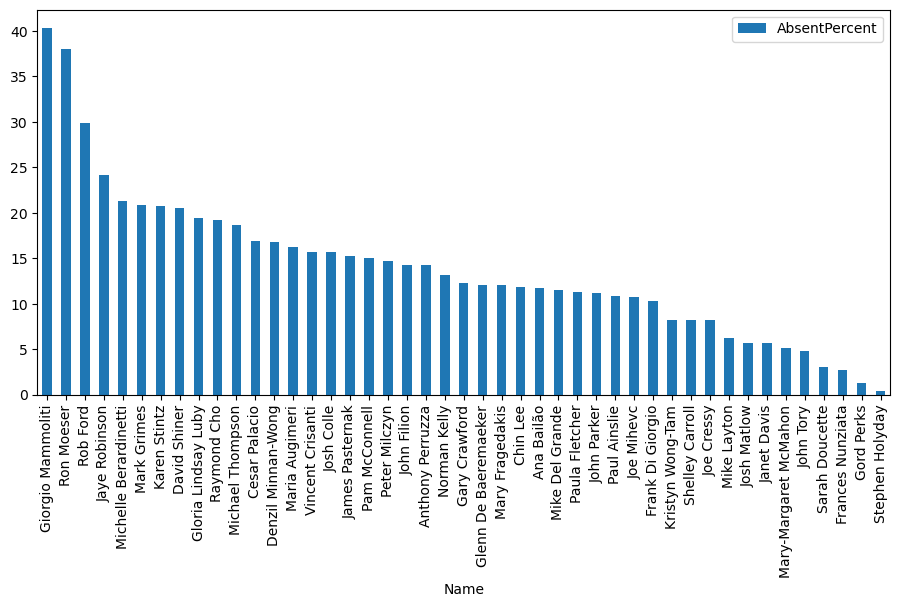

In [19]:
# Absenteeism is a more compelling way to view the data
attend_name_df['AbsentPercent'] = 100-attend_name_df['AttendancePercent']
attend_name_df.plot(kind='bar',x='Name',y='AbsentPercent',figsize=(11,5))

The attendance data doesn't offer us too many more insights, but it does give us one more tidbit when we group by `Session Type`:

In [10]:
# Make a copy to not alter the raw data
attend_session_df = raw_attendance_df.copy()

# Remove committee meetings, keep only council meetings
attend_session_df = attend_session_df.loc[attend_session_df['Committee']=='City Council']

# Converting 'Y' or 'N' into 1 or 0 is a handy trick to simplify this sort of data
attend_session_df['Present'] = np.where(attend_session_df['Present']=='Y', 1, 0)
attend_session_df = attend_session_df.groupby('Session Type')['Present'].agg(['count', 'sum'])
attend_session_df = attend_session_df.rename(columns={'count': 'TimesElegibleToAttend', 'sum': 'TimesPresent'}).reset_index()

# This is the column we've all been waiting for, how often did they attend meetings?
attend_session_df['AttendancePercent'] = 100 * attend_session_df['TimesPresent'] / attend_session_df['TimesElegibleToAttend']

display(attend_session_df.sort_values(by=['AttendancePercent'],ascending=True))

,Session Type,TimesElegibleToAttend,TimesPresent,AttendancePercent
1,Evening,9441,7687,81.421460
0,Afternoon,24806,21431,86.394421
2,Morning,19162,17138,89.437428


Councillors are early-birds, not night-owls!

---